# [Boosters] Raiffeisen Data Cup

Использован Baseline Антона Чикина.

Результат:
- Открытый рейтинг: 146 (0.3395)
- Финальный рейтинг: 160 (0.332583)

Общий подход:
- Добавляем к каждой транзакции столбец: is_work (если транзакция находится в пределах 0.02 от дома клиента)
- Добавляем к каждой транзакции столбец: is_home (если транзакция находится в пределах 0.02 от работы клиента)
- Обучаем классификатор предсказывающий вероятность (is_home == 1) для транзакции
- Обучаем классификатор предсказывающий вероятность (is_work == 1) для транзакции

Примечание
* Требуется Python версии 3.5
* Требуется библиотека xgboost (для обучения использовалась xgboost версии 0.7.post3)
* Требуются файлы: test_set.csv, train_set.csv в одном каталоге с данным скриптом
* Требования к памяти: должно работать с 2Гб свободного RAM

In [1]:
%%time
import pandas as pd
import numpy as np
import datetime

import xgboost as xgb
import sklearn

from sklearn.model_selection import train_test_split

import scipy.stats as stats
import pylab as pl

#Wall time: 563 ms

Wall time: 786 ms


In [2]:
# Определим типы колонок для экономии памяти
dtypes = {
    'transaction_date': str,
    'atm_address': str,
    'country': str,
    'city': str,
    'amount': np.float32,
    'currency': np.float32,
    'mcc': str,
    'customer_id': str,
    'pos_address': str,
    'atm_address': str,
    'pos_adress_lat': np.float32,
    'pos_adress_lon': np.float32,
    'pos_address_lat': np.float32,
    'pos_address_lon': np.float32,
    'atm_address_lat': np.float32,
    'atm_address_lon': np.float32,
    'home_add_lat': np.float32,
    'home_add_lon': np.float32,
    'work_add_lat': np.float32,
    'work_add_lon': np.float32,
}

# для экономии памяти будем загружать только часть атрибутов транзакций
usecols_train = ['customer_id','transaction_date','amount','country', 'city', 'currency', 'mcc', 'pos_adress_lat', 'pos_adress_lon', 'atm_address_lat', 'atm_address_lon','home_add_lat','home_add_lon','work_add_lat','work_add_lon']
usecols_test = ['customer_id','transaction_date','amount','country', 'city', 'currency', 'mcc', 'pos_address_lat', 'pos_address_lon', 'atm_address_lat', 'atm_address_lon']

## Читаем train_set, test_set, соединяем в один датасет

In [3]:
%%time
train = pd.read_csv('train_set.csv', dtype = dtypes, usecols = usecols_train, parse_dates=['transaction_date'])
train.rename(columns = {'pos_adress_lat': 'pos_address_lat', 'pos_adress_lon': 'pos_address_lon'}, inplace = True)

test = pd.read_csv('test_set.csv', dtype = dtypes, usecols = usecols_test, parse_dates=['transaction_date'])

# соединяем test/train в одном DataFrame
train['is_train'] = np.int32(1)
test['is_train'] = np.int32(0)
# Wall time: 6.73 s

Wall time: 20 s


In [4]:
dt = pd.concat([train, test], ignore_index=True)

In [5]:
# сохраняем полный список клиентов, чтобы никого не потерять
customer_ids = set(dt['customer_id'])

In [6]:
len(train), len(test), len(dt)

(1224734, 1265470, 2490204)

#### Исследование данных

In [7]:
# нет ли одинаковых пользователей в train и test
set(train['customer_id']).intersection(set(test['customer_id']))

set()

In [8]:
train.columns

Index(['amount', 'atm_address_lat', 'atm_address_lon', 'city', 'country',
       'currency', 'customer_id', 'home_add_lat', 'home_add_lon', 'mcc',
       'pos_address_lat', 'pos_address_lon', 'transaction_date',
       'work_add_lat', 'work_add_lon', 'is_train'],
      dtype='object')

In [9]:
test.columns

Index(['amount', 'atm_address_lat', 'atm_address_lon', 'city', 'country',
       'currency', 'customer_id', 'mcc', 'pos_address_lat', 'pos_address_lon',
       'transaction_date', 'is_train'],
      dtype='object')

In [10]:
# Определяем период дат (с 2017-01-27 по 2017-12-08)
train_transaction_date = train['transaction_date']
test_transaction_date = test['transaction_date']
min(train_transaction_date), max(train_transaction_date), min(test_transaction_date), max(test_transaction_date)

(Timestamp('2017-01-27 00:00:00'),
 Timestamp('2017-12-08 00:00:00'),
 Timestamp('2017-01-27 00:00:00'),
 Timestamp('2017-12-08 00:00:00'))

### Обрабатываем дату транзакции и категориальные признаки

In [11]:
%%time
# удаляем транзакции без даты
dt.drop(dt[dt['transaction_date'].isnull()].index, axis = 0, inplace = True)
# Wall time: 1.01 s

Wall time: 848 ms


In [12]:
len(dt)

2490159

In [13]:
%%time
# приводим код страны к одному виду
import pycountry
dt.loc[dt['country'] == 'ROM', 'country'] = 'ROU'
# на страну везде 3 символа, но местами их два и пробел
dt['country'] = dt['country'].str.strip();
dt.loc[dt['country'].str.len()==3, 'country'] = [pycountry.countries.get(alpha_3=alpha_3).alpha_2 for alpha_3 in dt[dt['country'].str.len()==3]['country']]
# Wall time: 2.2 s

Wall time: 6.82 s


In [14]:
dt['currency'] = dt['currency'].fillna(-1).astype(np.int32)
dt['mcc'] = dt['mcc'].apply(lambda x: int(x.replace(',', ''))).astype(np.int32)
dt['city'] = dt['city'].factorize()[0].astype(np.int32)
dt['country'] = dt['country'].factorize()[0].astype(np.int32)

### Фичи для даты

In [15]:
dt['weekday'] = dt['transaction_date'].dt.weekday.astype(np.int32)
weekend_2017 = ['2017-02-23', '2017-02-24', '2017-03-08', '2017-02-24', '2017-05-01', '2017-05-08', '2017-05-09', '2017-06-12', '2017-11-06']
dt['is_weekend'] = ((dt["weekday"] >= 5) | dt['transaction_date'].isin(weekend_2017)).astype(np.int32)

### Приводим адрес транзакции для pos и atm-транзакций к единообразному виду

In [16]:
dt['is_atm'] = (~dt['atm_address_lat'].isnull()).astype(np.int32)
dt['is_pos'] = (~dt['pos_address_lat'].isnull()).astype(np.int32)

dt['address_lat'] = dt['atm_address_lat'].fillna(0) + dt['pos_address_lat'].fillna(0)
dt['address_lon'] = dt['atm_address_lon'].fillna(0) + dt['pos_address_lon'].fillna(0)

In [17]:
print(dt['address_lat'].mean(), dt['address_lat'].std())
print(dt['address_lon'].mean(), dt['address_lon'].std())

51.7425 15.4645
37.293 16.9975


In [18]:
dt.drop(['atm_address_lat','atm_address_lon','pos_address_lat','pos_address_lon'], axis = 1, inplace = True)

In [19]:
# удалим транзакции без адреса
dt.drop(dt[((dt['address_lon'] == 0) & (dt['address_lon'] == 0))].index, axis = 0, inplace = True)

#### Исследование данных

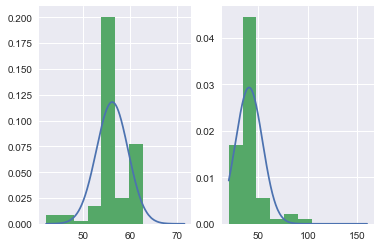

In [37]:
h = np.sort(dt['address_lat'])
fit = stats.norm.pdf(h, np.mean(h), np.std(h));
pl.figure
pl.subplot(1, 2, 1)
pl.plot(h,fit,'-')
pl.hist(h,normed=True);

h = np.sort(dt['address_lon'])
fit = stats.norm.pdf(h, np.mean(h), np.std(h));
pl.subplot(1, 2, 2)
pl.plot(h,fit,'-')
pl.hist(h,normed=True);
pl.show()

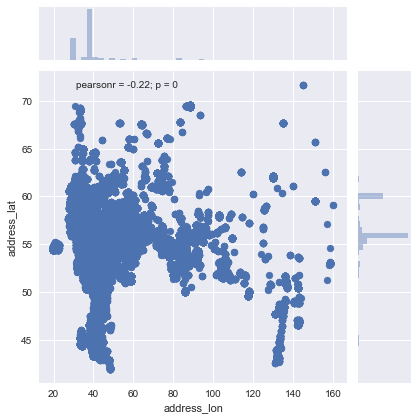

In [21]:
%matplotlib inline
import seaborn as sns
sns.set(color_codes=True)
sns.jointplot(x="address_lon", y="address_lat", data=pd.DataFrame(dt, columns=["address_lat", "address_lon"]));

### Генерируем признаки is_home, is_work

In [22]:
# для каждой транзакции вычисляем близко ли она от дома или работы 
lat = dt['home_add_lat'] - dt['address_lat']
lon = dt['home_add_lon'] - dt['address_lon']
dt['is_home'] = (np.sqrt((lat ** 2) + (lon ** 2)) <= 0.02).astype(np.int32)
dt['has_home'] = (~dt['home_add_lon'].isnull()).astype(np.int32)

lat = dt['work_add_lat'] - dt['address_lat']
lon = dt['work_add_lon'] - dt['address_lon']
dt['is_work'] = (np.sqrt((lat ** 2) + (lon ** 2)) <= 0.02).astype(np.int32)
dt['has_work'] = (~dt['work_add_lon'].isnull()).astype(np.int32)

#dt.drop(['work_add_lat','work_add_lon','home_add_lat','home_add_lon'], axis = 1, inplace = True)

### Фильтруем по стандартному отклонению
не зашло

In [ ]:
len(dt)

In [ ]:
%%time
# отсекаем то, что лежит за пределами стандартного отклонения от среднего
# сначала по долготе, это важно
dt = dt.merge(dt.groupby('customer_id')['address_lon'].mean().reset_index(name = 'mean_lon'), how = 'left')
dt = dt.merge(dt.groupby('customer_id')['address_lon'].std().fillna(0).reset_index(name = 'std_lon'), how = 'left')
dt['diff_mean_lon'] = abs(dt['mean_lon'] - dt['address_lon'])

dt = dt[dt['std_lon'] >= dt['diff_mean_lon']]
dt.drop(['mean_lon','std_lon','diff_mean_lon'], axis = 1, inplace = True)

In [ ]:
len(dt)

In [ ]:
%%time
# отсекаем то, что лежит за пределами стандартного отклонения от среднего
dt = dt.merge(dt.groupby('customer_id')['address_lat'].mean().reset_index(name = 'mean_lat'), how = 'left')
dt = dt.merge(dt.groupby('customer_id')['address_lat'].std().fillna(0).reset_index(name = 'std_lat'), how = 'left')
dt['diff_mean_lat'] = abs(dt['mean_lat'] - dt['address_lat'])
dt = dt[dt['std_lat'] >= dt['diff_mean_lat']]
dt.drop(['mean_lat','std_lat','diff_mean_lat'], axis = 1, inplace = True)

In [ ]:
len(dt)

In [ ]:
customer_ids_after = set(dt['customer_id'])

### Фильтруем по удалённости от медианного значения для каждого клиента
не зашло

In [ ]:
%%time
dt = dt.merge(dt.groupby('customer_id')['address_lon'].quantile(0.5, interpolation='nearest').reset_index(name = 'median_lon'), how = 'left')
dt['dist_lon'] = abs(dt['median_lon'] - dt['address_lon'])
dt = dt[dt['dist_lon']<2]
dt.drop(['median_lon','dist_lon'], axis = 1, inplace = True)
# Wall time: 3.35 s

In [ ]:
len(dt)

In [ ]:
%%time
dt = dt.merge(dt.groupby('customer_id')['address_lat'].quantile(0.5, interpolation='nearest').reset_index(name = 'median_lat'), how = 'left')
dt['dist_lat'] = abs(dt['median_lat'] - dt['address_lat'])
dt = dt[dt['dist_lat']<1]
dt.drop(['median_lat','dist_lat'], axis = 1, inplace = True)
# Wall time: 3.35 s

In [ ]:
len(dt)

In [ ]:
customer_ids_after = set(dt['customer_id'])

In [ ]:
# проверка
print(customer_ids_after.difference(customer_ids))
print(str(len(customer_ids_after.difference(customer_ids))) + ' строк лишних')
print(customer_ids.difference(customer_ids_after))
print(str(len(customer_ids.difference(customer_ids_after))) + ' строк не хватает')

### Генерируем категориальный признак для адреса

In [23]:
dt['address'] = dt['address_lat'].apply(lambda x: "%.02f" % x) + ';' + dt['address_lon'].apply(lambda x: "%.02f" % x)
dt['address'] = dt['address'].factorize()[0].astype(np.int32)

### Генерируем несколько абонентских фич

In [24]:
# количество транзакций каждого клиента
dt = dt.merge(dt.groupby('customer_id')['amount'].count().reset_index(name = 'tx'), how = 'left')
dt['tx'] = dt['tx'].astype(np.int32)

In [25]:
%%time
# количество транзакций каждого клиента на данный адрес в будни и выходные
dt = dt.merge(dt.groupby(['customer_id','address', 'is_weekend'])['amount'].count().reset_index(name = 'tx_cust_addr'), how = 'left')
dt['tx_cust_addr'] = dt['tx_cust_addr'].astype(np.int32)

# какая часть транзакций клиента приходится на данный адрес
dt['ratio2'] = dt['tx_cust_addr'] / dt['tx']

Wall time: 2.54 s


## Вспомогательные функции для оценки точности классификатора

In [26]:
def _best(x):
    ret = None
    for col in ys:
        pred = ('pred:%s' % col)
        if pred in x:
            i = (x[pred].idxmax())
            cols = [pred,'address_lat','address_lon']
            if col in x:
                cols.append(col)
            tmp = x.loc[i,cols]
            tmp.rename({
                'address_lat':'%s:add_lat' % col,
                'address_lon':'%s:add_lon' % col,
            }, inplace = True)
            if ret is None:
                ret = tmp
            else:
                ret = pd.concat([ret, tmp])
    return ret

In [27]:
def predict_proba(dt, ys = ['is_home', 'is_work']):
    for col in ys:
        pred = ('pred:%s' % col)
        dt[pred] = model[col].predict_proba(dt[xs])[:,1]
    return dt.groupby('customer_id').apply(_best).reset_index()

In [28]:
def score(dt, ys = ['is_home', 'is_work']):
    dt_ret = predict_proba(dt, ys)
    mean = 0.0
    for col in ys:
        col_mean = dt_ret[col].mean()
        mean += col_mean
    if len(ys) == 2:
        mean = mean / len(ys)
    return mean

### Признаки, на которых будем обучать модель

In [29]:
xs = ['amount','currency','country','mcc','is_atm','is_pos','is_weekend','ratio2']
ys = ['is_home', 'is_work']

# Создаем классификаторы

In [30]:
model0 = {
    'is_home': xgb.XGBClassifier(n_estimators = 100, n_jobs = 4),
    'is_work': xgb.XGBClassifier(n_estimators = 100, n_jobs = 4),
}

# Обучаем классификаторы

In [31]:
%%time
model = {}

# последовательно обучаем два классификатора
for col in ['is_home', 'is_work']:
    
    #выберем для обучение транзакции только тех клиентов из train, у которых хоть в одной транзакции указано место работы/жительства
    cust_train = dt[dt['is_train'] == 1].groupby('customer_id')[col.replace('is_','has_')].max()
    cust_train = cust_train[cust_train == 1].index
    
    #разобъем train на train/valid для валидации
    cust_train, cust_valid = train_test_split(cust_train, test_size = 0.1, shuffle = True, random_state = 2)
    
    train = pd.DataFrame(cust_train, columns = ['customer_id']).merge(dt, how = 'left')
    valid = pd.DataFrame(cust_valid, columns = ['customer_id']).merge(dt, how = 'left')

    print ("Training:", col)
    clf = sklearn.base.clone(model0[col])
    clf.fit(train[xs], train[col], eval_metric = 'logloss', eval_set = [(train[xs], train[col]), (valid[xs], valid[col])], verbose=10)
    model[col] = clf
    print ("Train accuracy:", score(train, ys = [col]))
    print ("Test accuracy:", score(valid, ys = [col]))
    print ()


Training: is_home
[0]	validation_0-logloss:0.660936	validation_1-logloss:0.659615
[10]	validation_0-logloss:0.528262	validation_1-logloss:0.521156
[20]	validation_0-logloss:0.502661	validation_1-logloss:0.494167
[30]	validation_0-logloss:0.494279	validation_1-logloss:0.485179
[40]	validation_0-logloss:0.490883	validation_1-logloss:0.482072
[50]	validation_0-logloss:0.488738	validation_1-logloss:0.480459
[60]	validation_0-logloss:0.487355	validation_1-logloss:0.479706
[70]	validation_0-logloss:0.486215	validation_1-logloss:0.478545
[80]	validation_0-logloss:0.485513	validation_1-logloss:0.477968
[90]	validation_0-logloss:0.484644	validation_1-logloss:0.477975
[99]	validation_0-logloss:0.484103	validation_1-logloss:0.477956
Train accuracy: 0.378222222222
Test accuracy: 0.371

Training: is_work
[0]	validation_0-logloss:0.647692	validation_1-logloss:0.6478
[10]	validation_0-logloss:0.457093	validation_1-logloss:0.458621
[20]	validation_0-logloss:0.417794	validation_1-logloss:0.421924
[30]	

# Predict

In [32]:
%%time
cust_test = dt[dt['is_train'] == 0]['customer_id'].unique()
test = pd.DataFrame(cust_test, columns = ['customer_id']).merge(dt, how = 'left')
test_res = predict_proba(test)

Wall time: 32.2 s


In [33]:
test_res.rename(columns = {
        'customer_id':'customer_id',
        'is_home:add_lat': 'home_add_lat',
        'is_home:add_lon': 'home_add_lon',
        'is_work:add_lat': 'work_add_lat',
        'is_work:add_lon': 'work_add_lon'}, inplace = True)
test_res_id = test_res[['customer_id', 'work_add_lat', 'work_add_lon', 'home_add_lat', 'home_add_lon']]

# Формируем submission-файл

In [34]:
submission = pd.DataFrame(test['customer_id'].unique(), columns = ['customer_id'])

# Заполняем пропуски
submission = submission.merge(test_res_id, how = 'left').fillna(0).sort_values(['customer_id'])

# Пишем файл submission
submission.to_csv('predict_100.csv', index = False, float_format='%.10f')

# Проверка валидности submission-файла

In [35]:
# от Иваницкий Илья и Amir Safiullin
import pandas as pd
import numpy as np

path_to_csv = 'predict_100.csv'
dfs = pd.read_csv('sample.csv')
df = pd.read_csv(path_to_csv)
assert df.shape == (9997, 5), u'Мало или много строк'

# несмотря на то, что названия не имеют особого значения, правильный порядк колонок позволит не запутаться в широте-долготе
# assert list(df.columns) == ['_ID_', '_WORK_LAT_', '_WORK_LON_', '_HOME_LAT_', '_HOME_LON_'], u'Неверные названия столбцов'
assert np.any(df['customer_id'].duplicated()) == False, u'Одному клиенту соответствует больше одной записи'
for col_name in df.columns:
    if col_name != 'customer_id':
        assert df[col_name].dtype in (np.float, np.int), u'В колонке {col_name} есть NULL'.format(col_name=col_name)
    assert df[col_name].isnull().sum() == 0, u'В колонке {col_name} есть NULL'.format(col_name=col_name)

In [36]:
# проверка на лишние строки
dfs2 = set(dfs['customer_id'])
df2 = set(df['customer_id'])
print(df2.difference(dfs2))
print(str(len(df2.difference(dfs2))) + ' строк лишних')
print(dfs2.difference(df2))
print(str(len(dfs2.difference(df2))) + ' строк не хватает')

set()
0 строк лишних
set()
0 строк не хватает
